# Classification

In [19]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isdir

# Image loading, binarization, inversion and display
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()

def resize_image(tmp_img, new_width, new_height):
    return cv2.resize(tmp_img, (int(round(new_width)), int(round(new_height))), interpolation = cv2.INTER_CUBIC)

# Image morphological operations
def dilate(image, kernel, iterations = 1):
    return cv2.dilate(image, kernel, iterations)
def erode(image, kernel, iterations = 1):
    return cv2.erode(image, kernel, iterations)
def open_image(image, kernel = None):
    if kernel is None:
        kernel = np.ones((1, 100))
    return dilate(erode(image, kernel), kernel)

# Horizontal projection
def horizontal_projection(image):
    hor_proj = []
    for i in range(len(image)):
        row_sum = 0
        for j in range(len(image[i])):
            row_sum += image[i][j] == 255
        hor_proj.append([255] * row_sum + [0] * (len(image[0]) - row_sum))

    return hor_proj

# Image crop
def crop_image(image, crop_start = None, crop_width = None):
    if crop_width is None:
        crop_width = len(image[0]) // 10
        
    if crop_start is None:
        end = 0
        for row in image:
            s = sum(row) / 255
            if s > end:
                end = s

        crop_start = end - crop_width
        
    cutoff = image[:]
    
    for i in range(len(cutoff)):
        cutoff[i] = cutoff[i][crop_start : crop_start + crop_width] 

    cutoff = np.array(cutoff, dtype = np.uint8)
    return cutoff

# Intersect two lists
def intersect_lists(first, second):
    ret_val = []
    for val in first:
        if val in second:
            ret_val += [val]
    return ret_val

# Line finding, labeling and removing functions

# Find Y coordinates of white pixels
def find_y(image):
    y = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in y):
                y.append(i)
    return sorted(y)

# Group points and get distances
def label_y(y_list):
    labels = [[]]
    line_distances = []
    prev_y = None
    for y in y_list:
        if prev_y is not None:
            if y - prev_y > 1:
                labels.append([])
                line_distances += [y - prev_y]
        labels[-1] += [y]
        prev_y = y
    return labels, line_distances

# Find lines
def find_lines(image):
    first = find_y(crop_image(horizontal_projection(image)))
    second = find_y(open_image(image))
    
    
    lines, distances = label_y(intersect_lists(first, second))
    staff_spacings = [distances[i] for i in range(len(distances)) if (i+1) % 5 != 0 ]
    staff_spacing = sum(staff_spacings) * 1./len(staff_spacings)
    return lines, distances, staff_spacing

# Remove lines
def remove_lines(org_image, tolerance = 0, lines = None, topBotPixelRemoval = True, widthBasedRemoval = True):
    image = org_image.copy()
    
    if lines == None:
        lines, distances, staff_spacing = find_lines(org_image)
    
    if topBotPixelRemoval:
        for line in lines:
            top = line[0]
            bot = line[-1]
            for j in range(len(image[top])):
                remove = True
                is_line = False
                for row in image[top:bot+1]:
                    if row[j] == 255:
                        is_line = True
                        break
                if not is_line:
                    continue
                # check 2 pixels above and below
                diff = 2
                for row in image[top - diff : top]:
                    if row[j] == 255:
                        remove = False
                        break
                if remove:
                    for row in image[bot + 1: bot + diff + 1]:
                        if row[j] == 255:
                            remove = False
                            break
                if remove:
                    for row in image[top:bot+1]:
                        row[j] = 0
    
    if widthBasedRemoval:
        avg_thickness = lines[:]
        for i, line in enumerate(avg_thickness):
            avg_thickness[i] = len(line)
        avg_thickness = sum(avg_thickness) * 1./len(avg_thickness)

        for j in range(len(image[0])):
            white = False
            for i in range(len(image)):
                if image[i][j] == 255:
                    if not white:
                        start = i
                    white = True
                else:
                    if white:
                        thickness = i - start
                        if thickness <= (avg_thickness + tolerance):
                            for row in image[start : i]:
                                row[j] = 0
                    white = False
    return image

# Region functions

# Search image for region containing pixel at row and col
# if it's a white pixel and add it to found regions
def add_region(image, row, col, regions, diff = 1):
    append = True
    coords = [(row, col)]
    idx = 0
    while (idx < len(coords)):
        row, col = coords[idx]
        for dr in range(-diff,diff + 1):
            for dc in range(-diff,diff + 1):
                r = row + dr
                c = col + dc
                if r >= 0 and c >= 0 and r < len(image) and c < len(image[r]):
                    if image[r][c] == 255 and ((r,c) not in coords):
                        skip = False
                        for region in regions:
                            if (r,c) in region:
                                skip = True
                                append = False
                                for coord in coords:
                                    region.append((r,c))
                        if not skip:
                            coords += [(r,c)]
        idx += 1
    if append:
        regions.append(coords)

# Morphological opening of image with vertical line kernel
def find_vertical_lines(image, staff_spacing = None):
    if staff_spacing is None:
        # Find lines, distances
        lines, distances, staff_spacing = find_lines(image)

    # Find vertical objects
    img_open = open_image(remove_lines(image), np.ones((1.5 * staff_spacing, 1)))
    return img_open

# Find and return regions from org_image, according to ref_image
def find_regions(org_image, ref_image = None, diff = 1):
    if ref_image is None:
        ref_image = org_image
    # Label regions of interest
    regions = []
    for row in range(len(ref_image)):
        for col in range(len(ref_image[row])):
            if ref_image[row][col] == 255:
                isFound = False
                for region in regions:
                    if (row,col) in region:
                        isFound = True
                        break
                if not isFound:
                    add_region(org_image, row, col, regions, diff)
    
    img_regions = org_image.copy()
    for row in range(len(img_regions)):
        for col in range(len(img_regions[row])):
            img_regions[row][col] = 0

    for region in regions:
        for row, col in region:
            img_regions[row, col] = 255
            
    return img_regions, regions

def find_vertical_objects(image, image_vert_lines = None, staff_spacing = None, diff = 1):
    if image_vert_lines is None:
        image_vert_lines = find_vertical_lines(image, staff_spacing)
    return find_regions(image, image_vert_lines, diff = diff)

# Additional image manipulation functions

# Split image to sub images that contain only the regions
def split_image(image, regions):
    split_images = []
    for region in regions:
        minr = min([r for r,c in region])
        maxr = max([r for r,c in region])
        minc = min([c for r,c in region])
        maxc = max([c for r,c in region])
        sub_image = []
        for row in range(minr,maxr+1):
            sub_image.append([])
            for col in range(minc,maxc+1):
                sub_image[-1] += [image[row][col]]
        sub_image = np.array(sub_image)
        sub_image = np.uint8(sub_image)
        split_images.append(sub_image)
    return split_images

# Remove white pixels from image1 if image2 contains them
def image_subtract(image1, image2):
    ret_image = image1.copy()
    for row in range(len(ret_image)):
        for col in range(len(ret_image[row])):
            if image2[row,col] == 255:
                ret_image[row,col] = 0

# Template matching functions

def search_for_templates(vertFile):
    templates = []
    split = vertFile.split('/')
    for listedFile in listdir("templates"):
        if listedFile == split[0]:
            for innerFile in listdir("templates/%s" % listedFile):
                if len(split) == 1 or innerFile.startswith(split[1]):
                    templates += ["templates/%s/%s" % (listedFile, innerFile)]
    return templates

# Return best match from templates for image containing the object
def match_object_with_size(obj, templates):
    obj_height, obj_width = obj.shape[:2]
    best_match = (None, 0)
    for template in templates:
        template_name = template
        # Template Image Processing
        template = load_image(template)
        template = resize_image(template,obj_width,obj_height)
        template = image_gray(template)
        template = image_bin_otsu(template)
        template = invert(template)
        match = 0
        for row in range(len(template)):
            for col in range(len(template[row])):
                match += 1 if obj[row][col] == template[row][col] else 0


        # Normalize
        match *= 1./(obj_width * obj_height)
        if match > best_match[1]:
            best_match = (template_name, match)
    print("Best match: %d%%" % (best_match[1]*100))
    print("Template name: %s" % best_match[0])
    return best_match

# General template matching
def match_object(obj, templates):
    object_height, object_width = obj.shape[:2]
    best_match = (None,(0,0),0)
    for templateName, template in templates.items():
        match_matrix = []
        for row in range(object_height - len(template) + 1):
            match_matrix.append([])
            for col in range(object_width - len(template[0]) + 1):
                match = 0
                for r in range(len(template)):
                    for c in range(len(template[r])):
                        match += 1 if obj[row + r ][col + c] == template[r][c] else 0
                match *= 1./(len(template) * len(template[0]))

                match_matrix[-1] += [match]
                if match > best_match[2]:
                    best_match = (templateName,(row,col),match)

    if best_match[0] is None:
        print("NO MATCH!")
    else:
        print("best match: %d%%" % (best_match[2]*100))
        print("templateName: %s" % best_match[0])
        print("rows: %s - %s" % (best_match[1][0], best_match[1][0] + len(templates[best_match[0]])))
        print("cols: %s - %s" % (best_match[1][1], best_match[1][1] + len(templates[best_match[0]][0])))
    return best_match

## Note beams
In this section we will try to recognize note beams, which are connecting two or more note stems.

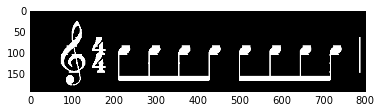

In [2]:
org_image = load_image("test_images/eighth_notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img)
display_image(img_wo_lines)
lines, distances, staff_spacing = find_lines(inv_img)

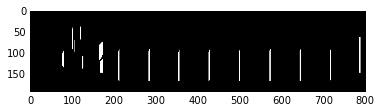

In [3]:
img_vert_lines = find_vertical_lines(inv_img)
display_image(img_vert_lines)

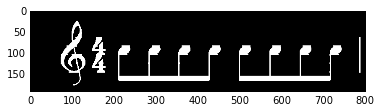

Number of recognized objects: 5


In [4]:
img_vert_objects, regions = find_vertical_objects(img_wo_lines, img_vert_lines)
display_image(img_vert_objects)
print("Number of recognized objects: %s" % len(regions))

As you can see, number of recognized regions is 5: 1 G-clef, 1 time signature (4/4), 8 eighth notes recognized as 2 regions and 1 barline.

To recognize the note beams we have to morphologically open the image with 3 kernels: a horizontal rectangle and its tilted versions (downwards and upwards by 15 degrees). For this image only the horizontal kernel is enough but we will use the other two as well.

The horizontal kernel should be wide as 2 of staff spacing and high as 0.5 of staff spacing.

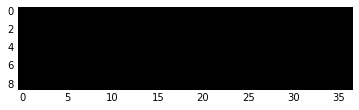

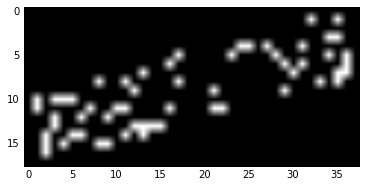

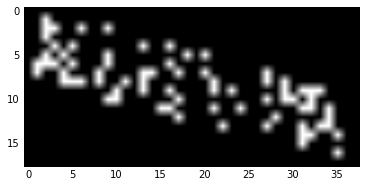

In [5]:
from scipy.ndimage.interpolation import rotate as rotate_matrix

rectangle_kernel = np.ones((0.5 * staff_spacing, 2 * staff_spacing))
kernels = [
    rectangle_kernel,
    np.uint8(rotate_matrix(rectangle_kernel,15)),
    np.uint8(rotate_matrix(rectangle_kernel,-15))
]
for kernel in kernels:
    display_image(kernel)

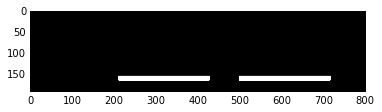

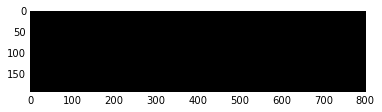

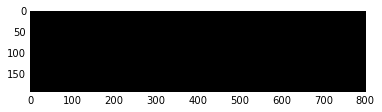

In [6]:
img_beams = []
for kernel in kernels:
    img_beams += [open_image(img_vert_objects, np.uint8(kernel))]
    display_image(img_beams[-1])

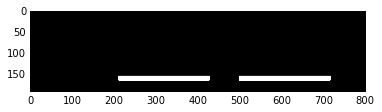

In [7]:
def merge_images(images):
    ret_image = images[0].copy()
    for image in images:
        for row in range(len(image)):
            for col in range(len(image)):
                if image[row,col] == 255:
                    ret_image[row,col] = 255
    return ret_image

img_beams = merge_images(img_beams)
display_image(img_beams)

Now we only need to memorize their regions and use them in semantics analysis.

## Time signatures

Now we'll try to recognize time signatures. They aren't that tricky but there are a few things to take care of:
1. Sometimes they are vertical objects (contain recognized vertical lines), sometimes they are not. It's best to start classifying them when recognizing non vertical objects
2. Sometimes they are recognized as one region, sometimes as two. When recognized as, they should be split in two regions (top half and bottom half, from the middle staff line) as separate numbers.
3. They are put either right of the bar line or right of the clef.

Now, we will concentrate on the time signature used in previous image, which is a vertical object recognized as one region, but these properties will be useful when recognizing a full music score.

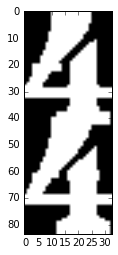

In [8]:
objects = split_image(img_vert_objects, regions)
display_image(objects[2])

Check if it's recognized as one region. We will suppose we already know it's right next to the clef.

In [9]:
obj = objects[2]
obj_height, obj_width = obj.shape[:2]
tolerance = 2
staff_height = lines[-1][-1] - lines[0][0] + 1
print obj_height
print staff_height
if staff_height + tolerance > obj_height > staff_height / 2 + tolerance:
    print("Nearly the same height as the whole staff! It's one region!")

84
84
Nearly the same height as the whole staff! It's one region!


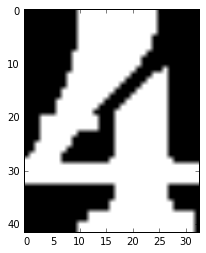

best match: 82%
templateName: templates/time/4_01.jpg
rows: 0 - 42
cols: 0 - 33


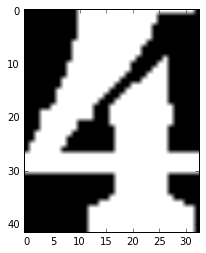

best match: 84%
templateName: templates/time/4_02.jpg
rows: 0 - 42
cols: 0 - 33


In [10]:
time_templates = search_for_templates("time")
top = obj[:staff_height/2]
display_image(top)

templates = {}
for templateName in time_templates:
    template = load_image(templateName)
    template = resize_image(template,len(top[0]),len(top))
    template = image_gray(template)
    template = image_bin_otsu(template)
    template = invert(template)
    templates[templateName] = template
    
match_object(top, templates)

bot = obj[staff_height/2:]
display_image(bot)

templates = {}
for templateName in time_templates:
    template = load_image(templateName)
    template = resize_image(template,len(bot[0]),len(bot))
    template = image_gray(template)
    template = image_bin_otsu(template)
    template = invert(template)
    templates[templateName] = template
    
match_object(bot, templates)

2-digit numbers may also be recognized sometimes as one, sometimes as two regions.

You can't split them if they are recognized as one, but you can make 2 digit templates.

If they are recognized as separate regions you can analyze if the second region is close enough to the first one to be classified as a digit.

## Bar lines
Bar lines are pretty easy. You check if their heights are nearly equal to the staff heights. Don't even need to template match them, but you can if you want to. They should be searched for after all other vertical objects were recognized.

## Flags
Flags are located on single eighth and sixteenth notes, that is on their stems. When recognizing vertical objects, remember the position of the note stems (if they truly are note stems), remove the from image, and find regions around it to template match them with flags.

## Rests
Some rests are vertical objects, like crotchet rest (1/4) and they can be recognized when searching for vertical objects. Most of the others should be recognized when recognizing non-vertical objects, like eighth, half or whole rests. Template match them with rest templates. Half and whole rests basically look the same, but are located on different lines, so you can differ them by that.

## Accidentals
Accidentals are basically vertical objects. However, sometimes they can be damaged during segmentation and can't be recognized that easily (especially flats). But, add_region function can now add white pixels that are more than 1 pixel away to the region. Another way is to morphologically dilate the image. Whatever the choice you make, do it after removing notes and their heads

## Duration dots
Sometimes to the right of the note head a dot may appear. It extends that note's duration by half. Recognize these dots with duration dot templates resized to half of staff spacing. Do this after recognizing vertical objects.